<a href="https://colab.research.google.com/github/lolaBerkowitz/NMA_HybridSeals/blob/master/LDA_SVM_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classification of miss/incorrect and correct trials using dimensionality reduction and SVM classification. 

* dataset: Steinmetz 2019 for NMA (39 sessions)


In [ ]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
!pip install sklearn-evaluation



In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
#@title Data loading
import numpy as np
import numpy.matlib as npm

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


In [ ]:
#@title Helper Functions

# Brain regions concatenated by functional area 
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
               ]


def find_cells(df,session,region,exlude_region = False):
  if exlude_region:
    cell_idx = (np.isin(df.session,session_list[0]) & np.isin(df.broad_region,region,invert = True))
    return df.cell[cell_idx]
  else:
    cell_idx = (np.isin(df.session,session_list[0]) & np.isin(df.broad_region,region))
    return df.cell[cell_idx]

def group_region(subregion,brain_groups):
  # subregion: list of regions
  # brain_groups: nested list of brain regions within broad area 
  #              (visual cortex, thalamus, hippocampus, other cortex)
  broad_region = [] # initalize list 
  for i in subregion:
      if np.isin(i,brain_groups[0]):
        broad_region.append('vis_ctx')
      elif np.isin(i,brain_groups[1]):
        broad_region.append('thal')
      elif np.isin(i,brain_groups[2]):
        broad_region.append('hipp')
      elif np.isin(i,brain_groups[3]):
        broad_region.append('other_ctx')
      else:
        broad_region.append('other')
  return broad_region

def get_session_list(dataframe,region):
  # lets get a list of sessions that we know contain the 
  #   brain region of interest.
  # input: 
  #   dataframe: dataframe with variables "session","mouse",
  #       "cell","broad_region","subregion" 
  #   region: string variable specifying broad region or 
  #       subregion of interest
  # output: 
  #   session_list: list of sessions that contain recordings 
  #       from area of interest.
  col = dataframe.columns[(dataframe.values==region).any(0)].tolist() #column name list
  if not col:
    raise Warning("Region not in dataset. Check spelling or try another name")
    return
  check = dataframe[col]
  idx = (check.values==region).any(1)
  subset_df = dataframe.loc[idx]
  subset_df = subset_df[['session','mouse']].drop_duplicates()
  session_list = subset_df

  return session_list

def get_even_samples(labels): # only deals with binary labels
  label1_num, label2_num = list(labels).count(0), list(labels).count(1)
  idx = np.linspace(0,len(labels)-1,num=len(labels))
  label1_idx = idx[labels==0]
  label2_idx = idx[labels==1]
  if label2_num > label1_num: # if 0 labels is greater than 1 label in number
    label2_idx_downsampl = np.random.choice(label2_idx,size=label1_num)
    label1_idx_downsampl = label1_idx
  elif label1_num > label2_num:
    label1_idx_downsampl = np.random.choice(label1_idx,size=label2_num)
    label2_idx_downsampl = label2_idx

  return  np.sort(label2_idx_downsampl).astype(int),label1_idx_downsampl.astype(int) # if labels has miss=0 and hits = 1, returns (hit_idx, miss_idx)

def get_labels_LDA(dat):

  difficulty= np.abs(dat['contrast_right'] - dat['contrast_left'])
  side = ((dat['contrast_right'] - dat['contrast_left']))
  choice = side < 0. # 1 = move right, 0 = move left

  # Create labels for hit/miss/correct
  hit_miss_incorrect = []
  for trial in range(len(dat['response'])):
    if np.logical_or(np.logical_and(dat['response'][trial]==0,dat['contrast_left'][trial]>0),np.logical_and(dat['response'][trial]==0,dat['contrast_right'][trial]>0)):
      hit_miss_incorrect.append(0) # add miss as '0' same as incorrect
    elif np.logical_or(np.logical_and(dat['response'][trial]>0,(dat['contrast_right'][trial] - dat['contrast_left'][trial])<0),np.logical_and(dat['response'][trial]<0,(dat['contrast_right'][trial] - dat['contrast_left'][trial])>0)):
      hit_miss_incorrect.append(1) # add hit as '1'
    elif np.logical_or(np.logical_and(dat['response'][trial]<0,(dat['contrast_right'][trial] - dat['contrast_left'][trial])<0),np.logical_and(dat['response'][trial]>0,(dat['contrast_right'][trial] - dat['contrast_left'][trial])>0)):
      hit_miss_incorrect.append(0) # add incorrect as '0' same as miss
    else:
      hit_miss_incorrect.append(3) # add random choice as '3'

  difficulty = np.hstack(difficulty)
  side = np.hstack(side)
  hit_miss_incorrect = np.hstack(hit_miss_incorrect)
  choice = np.hstack(choice)
  labels = np.array([hit_miss_incorrect,side,difficulty,choice]).T

  return labels

  
def get_binned_spikes(spikes,bin_down):
  binned_data_neurons = np.zeros([len(spikes[:,0])//bin_down,len(spikes[0,:])])
  print(np.shape(binned_data_neurons))   
  for neuron in range(0,len(spikes[0,:])):
    spike_train_to_bin = spikes[:,neuron]
    binned_spike_train = np.zeros(int(len(spike_train_to_bin)/bin_down))
    for bin_start in range (0,(len(spike_train_to_bin)-bin_down),bin_down):
      bin_num = int(bin_start/bin_down)
      bin_values_neurons = spike_train_to_bin[bin_start:(bin_start+bin_down)]
      binned_spike_train[bin_num] = np.sum(bin_values_neurons)
      binned_data_neurons[:,neuron] = binned_spike_train
  return binned_data_neurons, (binned_data_neurons>0).astype(int)

def get_binned_labels(data,bin_down):
  binned_data_columns = np.zeros([len(data[:,0])//bin_down,len(data[0,:])])
  print(np.shape(binned_data_columns))   
  for column in range(0,len(data[0,:])):
    time_series_to_bin = data[:,column]
    binned_series = np.zeros(int(len(time_series_to_bin)/bin_down))
    for bin_start in range (0,(len(time_series_to_bin)-bin_down+1),bin_down):
      bin_num = int(bin_start/bin_down)
      bin_values_series = time_series_to_bin[bin_start:(bin_start+bin_down)]
      binned_series[bin_num] = np.mean(bin_values_series)
      binned_data_columns[:,column] = binned_series
  return binned_data_columns


##Set up data frame

In [ ]:
# Set up data frame
# Build matrix of animals x Brain region (39 x nRegion Matrix)
import pandas as pd

# Initiate variables
cell_count = []
region_id = []
mouse_id = []
cell_id = []
session_id = []
num_spks = []
# Loop through sructure and get data
for i in range(alldat.shape[0]): #session
  sess = alldat[i]
  for ii in range(len(sess['spks'])):     # cell
    region_id.append(sess['brain_area'][ii])
    cell_id.append((ii))
    mouse_id.append(sess['mouse_name'])
    session_id.append(sess['date_exp'])
    num_spks.append(len(sess['spks'][ii]))

broad_region = group_region(region_id,brain_groups) # groups subregion into broad region (vis_ctx,thal,hipp,other_ctx)

# Create Pandas DF for ease of exploring
data = list(zip(session_id,mouse_id,cell_id,num_spks,broad_region,region_id))
df = pd.DataFrame(data,columns=['session','mouse','cell','num_spks','broad_region','subregion'])

# # Get list of sessions contain recordings of roi (can use broad_region or subregion ID)
vis = get_session_list(df,"vis_ctx") #for all hippocampal regions
thal = get_session_list(df,"thal") #for all hippocampal regions
hipp = get_session_list(df,"hipp") #for all hippocampal regions

s1 = pd.merge(vis, thal, how='inner', on=['session', 'mouse'])
s2 = pd.merge(s1, hipp, how='inner', on=['session', 'mouse'])

print(s2)

# # # find similarity between regions
# vis_thal, _, _ = np.intersect1d(vis, thal, return_indices=True)
# session_list, _, _ = np.intersect1d(vis_thal, hipp, return_indices=True)

# print('sessions to run: ' + str(len(session_list)))

# print(vis)

#Lets start by adding the tools we'll need for: 
* Creating Test, Train, and Validation sets from data (train_test_split)
* Organizing analysis pipeline to streamline process (Pipeline)
* Run hyperparameter optimazation (GridSearchCV)
* Fit model and run cross-validation on training data (KFold,cross_val_score)


In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import random
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


###This function will grab the cell indicies for the brain area you're interested in given a brain region



In [ ]:
# Grabs the cell index for a given session by region 
def get_session_cell_list(df,session_list,sess_it):

# # grab cells of interest Roi from session
  vis = []
  thal = []
  hipp = []
  idx_all = []
  vis = find_cells(df,session_list[sess_it],'vis_ctx')
  thal = find_cells(df,session_list[sess_it],'thal')
  hipp = find_cells(df,session_list[sess_it],'hipp')
  idx_all.append(np.hstack((vis.copy(),thal.copy(),hipp.copy())))
  idx_all = idx_all[0]
  return vis, thal, hipp, idx_all

#test
# vis,thal,hipp,idx_all = get_session_cell_list(df,session_list,0)
# print(vis.shape)
# print(hipp.shape)
# print(len(idx_all))
# print(thal.shape)

### This function will grab the categorical data for a given session

In [ ]:
# Grab the spike data for a given region (cell_list) in a given session (sess_num) from all the data (alldat)
def get_session_data_labels(alldat,cell_list,sess_num):
  # Grab session data
  dat = alldat[sess_num]
  cells = dat['spks'][cell_list]

  # n_trials x context 
  labels = get_labels_LDA(dat) 
  return cells, labels

#test 
# cells, labels = get_session_data_labels(alldat,thal,9)


##Organize the data into proper format for LDA 
* Xt = matrix of number of trials (rows) by neurons (columns). 
* Trial data consists of binned spikes across entired 2500ms trial duration.
* labels for lda, first column corresponds to incorrect/miss = 0, hit = 1, random = 2. 

In [ ]:
# Get data into trials x n cells x time (250 bins)

def get_matrices(cells,labels,measure): 
  X = cells.T.transpose(1,2,0) # transpose allows for the trials to be 0th dim
  Xt = X.sum(axis=2)
  y = labels[:,measure] 

  return Xt,y

#test
# X,y = get_matrices(cells,labels,0)
# print(X.shape)
# print(y.shape)

###This function identifies and saves best model determined by GridSearchCV using RepeatedKfold crossvaliation. Model performance is plotted


Use Pipeline function to orgnaize process:
1. Scale data 
2. Perform LDA specifiying 2 components OR use linear support vector machine for classification 
4. Set parameters to optimize solver/shrinkage (LDA) or Regularization (SVC) (e.g. L1 or L2)




In [ ]:
### Set Testing Parameters
# Create pipeline
pipe_clf = Pipeline([
      ('scaler', StandardScaler()),
      ('clf', svm.LinearSVC(max_iter=10000))])

# Set parameters to test during optimization
param_grid_clf = [
   { 
        "clf__penalty": ["l2"],
        "clf__dual":[False,True]
   },
   { 
        "clf__penalty": ["l1"],
        "clf__dual":[False]
   }    
]

# Create pipeline
pipe_lda = Pipeline([
      ('scaler', StandardScaler()),
      ('lda', LinearDiscriminantAnalysis(n_components=2))])

# Set parameters to test during optimization
param_grid_lda = [
   { 
        "lda__solver": ["eigen"],
        "lda__shrinkage":["auto"]
   },
   { 
        "lda__solver": ["lsqr"],
        "lda__shrinkage":["auto"]
   }    
]

# Define function
def model_selection(X,y,pipe,param_grid):
  # See if L1 or L2 regularization leads to better classification accuracy with 5 fold cross validation
  cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)
  grid = GridSearchCV(pipe, cv=cv, param_grid=param_grid)
  grid.fit(X,y)

  # Print Summary of the results
  print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
  means = grid.cv_results_['mean_test_score']
  stds = grid.cv_results_['std_test_score']
  params = grid.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

  # save the best model
  model = grid.best_estimator_

  return model

#test 
# lda_best = model_selection(X,y,pipe_lda,param_grid_lda)
# clf_best = model_selection(X,y,pipe_clf,param_grid_clf)

###This function will run RepeatedKfold cross validation on a given model. Output's performance metrics. 




In [ ]:
def run_model_cv(model,X_train,y_train,X_test,y_test):
  cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 2020)
  scores = cross_val_score(model, X_train, y_train, cv = cv) # 5-fold repeated cross validation
  print('Mean Accuracy: ',scores.mean())

  # Plot summary of accuracy results (ala of Di from knowing grebes' github)
  f, ax = plt.subplots(figsize=(8, 3))
  ax.boxplot(scores, vert=False, widths=.7)
  ax.scatter(scores, np.ones(50))
  ax.set(
    xlabel="Accuracy",
    yticks=[],
    title=f"Average test accuracy: {scores.mean():.2%}"
  )
  ax.spines["left"].set_visible(False)

  predicted = model.predict(X_test)
  # Get metrics for model
  mets = metrics.classification_report(y_test,predicted)
  return mets, predicted, scores

##Okay, lets reduce some dimensions using LDA and compare accuracy

In [ ]:
# And now make some pretty plots 
cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 2021)
lda = LinearDiscriminantAnalysis(n_components=2, priors=None,shrinkage='auto', solver='eigen',store_covariance=False,tol=0.0001)
scores = cross_val_score(lda, X_train, y_train, cv = cv) # 5-fold repeated cross validation
print('Mean Accuracy: ',scores.mean())

# Plot summary of accuracy results (ala of Di from knowing grebes' github)
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(scores, vert=False, widths=.7)
ax.scatter(scores, np.ones(50))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {scores.mean():.2%}"
)
ax.spines["left"].set_visible(False)
fig.savefit()
x = lda.fit_transform(X_train,y_train)
x_test = lda.fit_transform(X_test,y_test)

plt.figure()
plt.scatter(x[:,0],x[:,1],c = y_train.astype(int),cmap = 'jet')
plt.title('Training Set')
fig.savefig('training.pdf')
plt.show()

plt.figure()
plt.scatter(x_test[:,0],x_test[:,1],c = y_test.astype(int),cmap = 'jet')
plt.title('Test Set')
fig.savefig('test.pdf')
plt.show()  


In [ ]:
print(session_list)

[]


In [ ]:
# Loop through example session

sess_num = to_run[s]

vis,thal,hipp,idx_all = get_session_cell_list(df,session_list,s)
area_list = [vis,thal,hipp,idx_all]

for c in range(4): #loop through cells

  print(len(area_list[c]))
  print('region:', c)
  cells =[]
  labels = []
  # get session data
  cells, labels = get_session_data_labels(alldat,area_list[c],sess_num)

  # get predictor matrices 
  X,y = get_matrices(cells,labels,0)

  # Split the data into test(60%), train(20%), and validation(20%) sets
  # Split the data into Training and Test Set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

  # Further split training set (.80) into validation set (.20) to get new training set (.60)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

  # Set parameters to test during optimization for linearSVC
  param_grid_clf = [
    { 
        "clf__penalty": ["l2"],
        "clf__dual":[False,True]
    },
    { 
        "clf__penalty": ["l1"],
        "clf__dual":[False]
    }    
  ]

  # Create pipeline
  pipe_lda = Pipeline([
          ('scaler', StandardScaler()),
        ('lda', LinearDiscriminantAnalysis(n_components=2))])

  # Set parameters to test during optimization for LDA
  param_grid_lda = [
    { 
          "lda__solver": ["eigen"],
          "lda__shrinkage":["auto"]
    },
    { 
          "lda__solver": ["lsqr"],
          "lda__shrinkage":["auto"]
    }    
  ]

  # Find Best model
  lda_best = model_selection(X_train,y_train,pipe_lda,param_grid_lda)
  clf_best = model_selection(X_train,y_train,pipe_clf,param_grid_clf)

  # Split the data into Training and Test Set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

  # Run the lda model
  cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 2021)
  lda = LinearDiscriminantAnalysis(n_components=2, priors=None,shrinkage='auto', solver='eigen',store_covariance=False,tol=0.0001)
  scores = cross_val_score(lda, X_train, y_train, cv = cv) # 5-fold repeated cross validation
  print('Mean Accuracy: ',scores.mean())

  # Plot summary of accuracy results (ala of Di from knowing grebes' github)
  f, ax = plt.subplots(figsize=(8, 3))
  ax.boxplot(scores, vert=False, widths=.7)
  ax.scatter(scores, np.ones(50))
  ax.set(
    xlabel="Accuracy",
    yticks=[],
    title=f"Average test accuracy: {scores.mean():.2%}"
  )
  ax.spines["left"].set_visible(False)

  x = lda.fit_transform(X_train,y_train)
  x_test = lda.fit_transform(X_test,y_test)

  plt.figure()
  plt.scatter(x[:,0],x[:,1],c = y_train.astype(int),cmap = 'jet')
  plt.title('Training Set')
  plt.show()

  plt.figure()
  plt.scatter(x_test[:,0],x_test[:,1],c = y_test.astype(int),cmap = 'jet')
  plt.title('Test Set')
  plt.show()  

# Run SCV on LDA embeddings
  clf = svm.LinearSVC(C=1.0, class_weight=None, dual=False,
                          fit_intercept=True, intercept_scaling=1,
                          loss='squared_hinge', max_iter=10000,
                          multi_class='ovr', penalty='l1', random_state=None,
                          tol=0.0001, verbose=0)

  cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 2032)
  scores = cross_val_score(clf, x, y_train, cv = cv) # 5-fold repeated cross validation
  print('Mean Accuracy: ',scores)

  # Plot summary of accuracy results (ala of Di from knowing grebes' github)
  f, ax = plt.subplots(figsize=(8, 3))
  ax.boxplot(scores, vert=False, widths=.7)
  ax.scatter(scores, np.ones(50))
  ax.set(
    xlabel="Accuracy",
    yticks=[],
    title=f"Average test accuracy: {scores.mean():.2%}"
  )
  ax.spines["left"].set_visible(False)

  linear_svm = clf.fit(x,y_train)
  line = np.linspace(-15, 15)  
  for coef, intercept in zip(linear_svm.coef_, linear_svm.intercept_):  
      plt.plot(line, -(line * coef[0] + intercept) / coef[1])  #HOW DO WE KNOW
  plt.ylim(-10, 15)  
  plt.xlim(-10, 8) 
  plt.scatter(x[:,0],x[:,1]) 
  plt.show() 


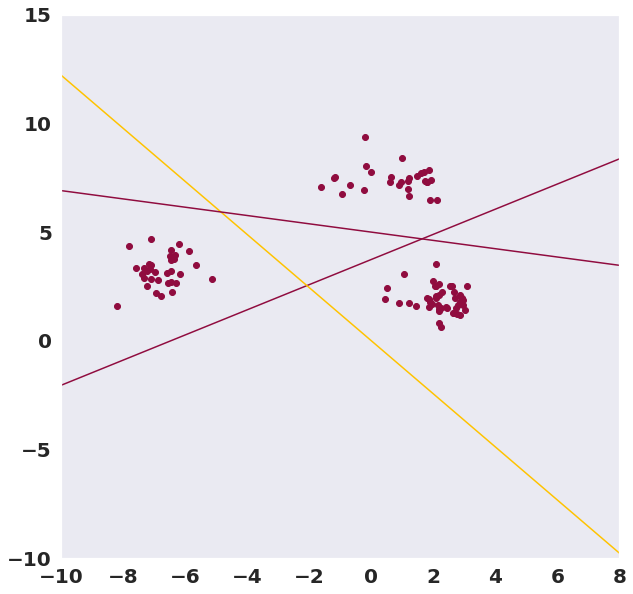

In [ ]:
c = ['#581845','#FF5733','#FFC300']

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.rcParams['image.cmap'] = "twilight"
  
linear_svm = clf.fit(x,y_train)
plt.figure(figsize=(10,10))
line = np.linspace(-15, 15)  
for coef, intercept in zip(linear_svm.coef_, linear_svm.intercept_):  
      plt.plot(line, -(line * coef[0] + intercept) / coef[1])  #HOW DO WE KNOW
plt.ylim(-10, 15) 
plt.xlim(-10, 8) 
plt.scatter(x[:,0],x[:,1]) 
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.show() 

##Use reduced data as input to linear SCV


Mean Accuracy:  [0.88571429 0.94117647 0.91176471 0.94117647 0.82352941 0.94285714
 0.88235294 0.91176471 0.82352941 0.91176471 0.91428571 0.91176471
 0.88235294 0.88235294 0.94117647 0.94285714 0.82352941 0.94117647
 0.88235294 0.88235294 0.97142857 0.79411765 0.91176471 0.88235294
 0.97058824 0.94285714 0.94117647 0.82352941 0.91176471 0.88235294
 0.94285714 0.88235294 0.91176471 0.91176471 0.88235294 0.88571429
 0.94117647 0.88235294 0.91176471 0.88235294 0.85714286 0.97058824
 0.82352941 0.91176471 0.91176471 0.94285714 0.88235294 0.82352941
 0.91176471 0.91176471]


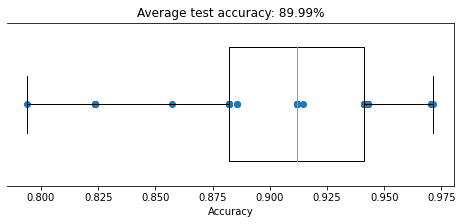

In [ ]:
clf = svm.LinearSVC(C=1.0, class_weight=None, dual=False,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=10000,
                           multi_class='ovr', penalty='l1', random_state=None,
                           tol=0.0001, verbose=0)

cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 2032)
scores = cross_val_score(clf, x, y_train, cv = cv) # 5-fold repeated cross validation
print('Mean Accuracy: ',scores)

# Plot summary of accuracy results (ala of Di from knowing grebes' github)
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(scores, vert=False, widths=.7)
ax.scatter(scores, np.ones(50))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {scores.mean():.2%}"
)
ax.spines["left"].set_visible(False)

##Create plots to show SVC results 

In [ ]:
linear_svm = clf.fit(x,y_train)
line = np.linspace(-15, 15)  
for coef, intercept in zip(linear_svm.coef_, linear_svm.intercept_):  
    plt.plot(line, -(line * coef[0] + intercept) / coef[1])  #HOW DO WE KNOW
plt.ylim(-10, 15)  
plt.xlim(-10, 8) 
plt.scatter(x[:,0],x[:,1]) 
plt.show() 



In [ ]:
#@title Broken first attempt at pipeline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import seglearn as sgl


def plot_embedding(emb, y, y_labels):
    # plot a 2D feature map embedding
    x_min, x_max = np.min(emb, 0), np.max(emb, 0)
    emb = (emb - x_min) / (x_max - x_min)

    NC = len(y_labels)
    markers = ['.', '+', 'x', '|', '_', '*', 'o']

    fig = plt.figure()
    fig.set_size_inches(6, 6)

    for c in range(NC):
        i = y == c
        plt.scatter(emb[i, 0], emb[i, 1], marker=markers[c], label=y_labels[c])

    plt.xticks([]), plt.yticks([])
    plt.legend()
    plt.tight_layout()


# Find sessions with recordings from ROI 
idx = []
[idx.append(ses) for ses in range(len(alldat)) if np.isin(alldat[ses]['date_exp'],session_list.copy())]

# Get data
dat = alldat[idx[0]]

# n_trials x context 
labels = get_labels_LDA(dat) 

# grab cells of interest Roi from session
cell_idx = find_cells(df,session_list[0],'vis_ctx')

# n cells x trials x time 
cells = dat['spks'][cell_idx]
 
# Get data into trials x n cells x time
X = cells.T.transpose(1,2,0)
y = labels[:,0]

# create a pipeline for LDA transformation of the feature representation
clf = sgl.Pype([('segment', sgl.Segment()),
                ('ftr', sgl.FeatureRep()),
                ('lda', LinearDiscriminantAnalysis(n_components=2))])

X2, y2 = clf.fit_transform(X, y)
plt.figure()
